## Figure 2.C
### Comparison of RNA004 U-to-C mismatch percentage to Dorado Ψ reported occupancy for reads with valid coverage of 20.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import sys
import time
import pickle
import os.path as osp
import tqdm
import pysam
import seaborn as sns
from matplotlib_venn import venn3, venn2
from sklearn.metrics import mean_squared_error

## Intersection of U-to-C with modkit for rna4

In [2]:
# intersecting modkit and pysamstats

modkit_df = pd.read_csv('08_07_24_R9RNA_GM12878_mRNA_RT_sup_8mods_polyA_sorted_filtered.chr12-112000000-114000000_modkit_ivt_correct.tsv', sep='\t')

modkit_df.columns = [
    "chrom", "start_position", "end_position", "modified_base_code", "score", 
    "strand", "start_position_compat", "end_position_compat", "color", 
    "Nvalid_cov", "fraction_modified", "Nmod", "Ncanonical", "Nother_mod", 
    "Ndelete", "Nfail", "Ndiff", "Nnocall", "ivt_correct"
]
## fitering for >= 20 reads coverage
modkit_df = modkit_df[modkit_df["score"] >= 20]

## filtering for Psi mod code
modkit_df = modkit_df[modkit_df['modified_base_code'].astype(str) == "17802"]

pysamstats_df = pd.read_csv('RNA004_table_T2C_A2G.csv', sep="\t") 

# intersection based on the 'end_position' in modkit and 'pos' in pysamstats
intersection_df = pd.merge(modkit_df, pysamstats_df, left_on=['chrom','end_position'], right_on=['chrom','pos'])

intersection_df.to_csv('./modkit_pysamstats_RNA4_C_G.csv', sep=',', index=False)

print(intersection_df.head())

len(intersection_df)

   chrom  start_position  end_position modified_base_code  score strand  \
0  chr12       111931317     111931318              17802     21      -   
1  chr12       111931326     111931327              17802     27      -   
2  chr12       111931328     111931329              17802     29      -   
3  chr12       111931329     111931330              17802     26      -   
4  chr12       111931331     111931332              17802     31      -   

   start_position_compat  end_position_compat    color  Nvalid_cov  ...  \
0              111931317            111931318  255,0,0          21  ...   
1              111931326            111931327  255,0,0          27  ...   
2              111931328            111931329  255,0,0          29  ...   
3              111931329            111931330  255,0,0          26  ...   
4              111931331            111931332  255,0,0          31  ...   

         pos  ref   A  C  G  T  A_perc  C_perc  G_perc  T_perc  
0  111931318    A  21  0  0  0   

15127

## Dorado vs RNA004 U-to-C Mismatch Ratio

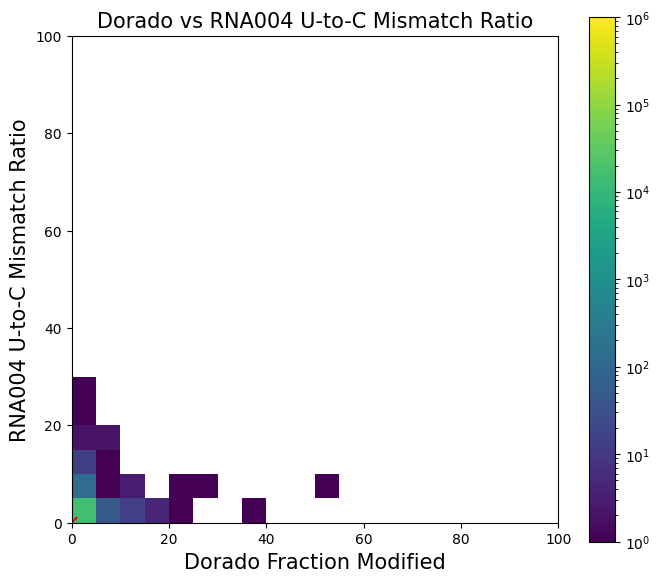

In [3]:
df = pd.read_csv('./modkit_pysamstats_RNA4_C_G.csv', sep=',')

df['mismatch_perc'] = np.where(df['ref'] == 'T', df['C_perc'], df['G_perc'])
df['mismatch_perc'] *= 100

fig, ax = plt.subplots()
fig.set_size_inches(7, 6)

cmap = mpl.cm.viridis
cmap.set_bad('white', 1.)

bandwidth_2d = 5
bins = np.arange(0, 100 + bandwidth_2d, bandwidth_2d)

hist = ax.hist2d(df['fraction_modified'], df['mismatch_perc'], 
                 bins=[bins, bins], norm=mpl.colors.LogNorm(vmin=1, vmax=1e6), cmap=cmap)

ax.plot((0.0, 1), (0.0, 1), color='red', alpha=1)
ax.set_xlabel('Dorado Fraction Modified', fontsize=15)
ax.set_ylabel('RNA004 U-to-C Mismatch Ratio', fontsize=15)
ax.set_title('Dorado vs RNA004 U-to-C Mismatch Ratio', fontsize=15)
fig.colorbar(hist[3], ax=ax)
ax.set_xlim(0.0, 100)
ax.set_ylim(0.0, 100)
ax.set_aspect('equal')

ax.tick_params(axis='both')
for spine in ax.spines.values():
    spine.set_edgecolor('black')

fig.tight_layout()
plt.show()

### RMSE between Dorado fraction_modified and RNA004 U-to-C mismatch_perc

In [4]:
# RMSE
df['mismatch_perc'] = np.where(df['ref'] == 'T', df['C_perc'], df['G_perc'])

df['fraction_modified'] /= 100

valid = df[(df['mismatch_perc'] > 0) & (df['fraction_modified'] > 0)]


mse = mean_squared_error(valid['fraction_modified'], valid['mismatch_perc'])
rmse = np.sqrt(mse)

print(f"RMSE between Dorado fraction_modified and RNA004 U-to-C mismatch_perc: {rmse:.4f}")

RMSE between Dorado fraction_modified and RNA004 U-to-C mismatch_perc: 0.0302
